In [1]:
import numpy as np
import pandas as pd
import pathlib
from tqdm.auto import tqdm

import ray

In [2]:
import torch.nn as nn
import PIL
from typing import Union
from random import choice
import torchvision as tv
import torchvision.transforms.functional as TF

import torch
import torchvision.transforms as transforms
from skimage.io import imread

crop_ratio = [0.66]
img_size_to_gpu = 384

class AdaptiveRandomCropTransform(nn.Module):
    def __init__(self,
                 crop_ratio: Union[list,float],
                 out_size: int,
                 interpolation=PIL.Image.BILINEAR):
        super().__init__()
        self.crop_ratio = crop_ratio
        self.out_size = out_size
        self.interpolation = interpolation

    def forward(self, sample):
        input_size = min(sample.size)
        if isinstance(self.crop_ratio, list):
            crop_ratio = choice(self.crop_ratio)
        else:
            crop_ratio = self.crop_ratio

        crop_size = int(crop_ratio * input_size)
        if crop_size < self.out_size:
            crop_size = tv.transforms.transforms._setup_size(self.out_size,
                                                             error_msg="Please provide only two dimensions (h, w) for size.")
            i, j, h, w = transforms.RandomCrop.get_params(sample, crop_size)
            return TF.crop(sample, i, j, h, w)
        else:
            crop_size = tv.transforms.transforms._setup_size(crop_size,
                                                             error_msg="Please provide only two dimensions (h, w) for size.")
            i, j, h, w = transforms.RandomCrop.get_params(sample, crop_size)
            cropped = TF.crop(sample, i, j, h, w)
        out = TF.resize(cropped, self.out_size, self.interpolation)
                        
        return out
    
# Define the transforms to apply
transform = transforms.Compose([
    AdaptiveRandomCropTransform(crop_ratio=crop_ratio,
                                out_size=img_size_to_gpu,
                                interpolation=PIL.Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
                    
])

invTrans = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406],  std = [ 1., 1., 1. ])])

/tmp/ipykernel_62298/2039152510.py:19: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation=PIL.Image.BILINEAR):
/tmp/ipykernel_62298/2039152510.py:51: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation=PIL.Image.BICUBIC),


In [3]:
def prep_image(img_name):
    
    try:
        img_np = imread(f"../Data/EPICImages/{img_name}")
    except:
        img_np = imread(f"../Data/EPICImages_PoorQuality/{img_name}")

    img_pil = PIL.Image.fromarray(img_np)
    
    imgs_transformed = []
    for i in range(1):
        img_tensor = transform(img_pil)
        imgs_transformed.append(img_tensor)
    #img_batch = torch.unsqueeze(img_tensor, 0)
    
    return torch.stack(imgs_transformed)

In [23]:
endpoints_md = pd.read_csv("../onnx/endpoints.csv").drop(columns="Unnamed: 0")#[["endpoint", "eligable", "n", "freq", "phecode", "phecode_string", "phecode_category", "sex"]]
endpoints_md

endpoint  eligable     n      freq     phecode  \
0       OMOP_4306655     61256  3548  0.057921  4306655.00   
1        phecode_002     60945   658  0.010797        2.00   
2      phecode_002-1     61010   486  0.007966        2.10   
3        phecode_003     60757  1017  0.016739        3.00   
4        phecode_004     60584   494  0.008154        4.00   
...              ...       ...   ...       ...         ...   
1166  phecode_977-52     31669   520  0.016420      977.52   
1167   phecode_977-7     60032  2231  0.037164      977.70   
1168  phecode_977-71     60936   472  0.007746      977.71   
1169  phecode_977-72     60207  2148  0.035677      977.72   
1170     phecode_979     61159   158  0.002583      979.00   

                                         phecode_string phecode_category  \
0                                       All-Cause Death            Death   
1                                        Staphylococcus               ID   
2                                 Staphylococcus aureus               ID   
3                                      Escherichia coli               ID   
4                                         Streptococcus               ID   
...                                                 ...              ...   
1166       Hormone replacement therapy (postmenopausal)               Rx   
1167  Long term (current) use of insulin or oral hyp...               Rx   
1168                 Long term (current) use of insulin               Rx   
1169  Long term (current) use of oral hypoglycemic d...               Rx   
1170                                  Transplated organ             Stat   

         sex  
0       Both  
1       Both  
2       Both  
3       Both  
4       Both  
...      ...  
1166  Female  
1167    Both  
1168    Both  
1169    Both  
1170    Both  

[1171 rows x 8 columns]

In [24]:
import os
import onnx
import onnxoptimizer
import onnxruntime as ort
import numpy as np
import concurrent.futures
import pandas as pd
from tqdm import tqdm

partitions = [p for p in range(22)]

# Optimize the ONNX model
def optimize_onnx_model(model_path):
    model = onnx.load(model_path)
    optimized_model = onnxoptimizer.optimize(model)
    return optimized_model.SerializeToString()

# Load optimized ONNX models
optimized_encoder_models = [optimize_onnx_model(f'../onnx/models/{p}_encoder.onnx') for p in tqdm(partitions)]
optimized_head_models = [optimize_onnx_model(f'../onnx/models/{p}_head.onnx') for p in tqdm(partitions)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.46it/s]


In [27]:
# Predict function
def predict_batch(img_batch, partition):
    
    loghs = []

    onnx_encoder = ort.InferenceSession(optimized_encoder_models[partition])
    latent = onnx_encoder.run(None, {'input': img_batch.numpy()})

    onnx_head = ort.InferenceSession(optimized_head_models[partition])
    loghs_partition = onnx_head.run(None, {'input': latent[0]})[1]
    loghs.append({"partition": partition, "loghs": loghs_partition})
    
    return loghs

# Preprocessing and inference pipeline
def process_image(img_name, partition):
    img_batch = prep_image(img_name)
    loghs = predict_batch(img_batch, partition)
    return loghs

data_images = pd.read_stata("../Data/StudyData/BiHealth_20230313_Long.dta")

In [ ]:
rows = []
for partition in partitions[:1]:
    for index, row in tqdm(data_images.iterrows(), total=len(data_images)):
        img_name = row["distfilename"]
        try:
            loghs = process_image(img_name, partition)
            row = {"partition": partition, "img_name":img_name, "loghs": loghs}
        except:
            row = {"partition": partition, "img_name":img_name, "loghs": np.array([])}
        rows.append(row)

  5%|███████▍                                                                                                                                      | 840/16042 [06:38<1:57:28,  2.16it/s]

In [ ]:
rows

In [ ]:
# Use a ThreadPoolExecutor to parallelize the processing of images
num_threads = 20
with concurrent.futures.ThreadPoolExecutor(num_threads) as executor:
    rows = list(tqdm(executor.map(process_image, *zip(*data_images.iterrows())), total=len(data_images)))

In [ ]:
device_preference

In [131]:
pd.DataFrame(loghs, columns=endpoints_md.endpoint).assign(i

endpoint  OMOP_4306655  phecode_002  phecode_002-1  phecode_003  phecode_004  \
0             0.897652     2.245491       1.786840     2.609609     1.738475   
1             0.936914     2.348968       1.894057     2.700113     1.810696   
2             1.296214     2.765414       2.315022     3.039274     2.121109   
3             1.295641     2.728696       2.283201     2.996991     2.096114   
4             1.804502     3.311752       2.916841     3.552967     2.652513   
..                 ...          ...            ...          ...          ...   
95            1.543411     3.015144       2.598328     3.233746     2.345168   
96            1.158233     2.472234       2.026392     2.793299     1.988984   
97            1.826293     3.150993       2.749703     3.361649     2.531297   
98            1.689776     3.114063       2.713744     3.339479     2.489950   
99            1.217944     2.485275       2.041434     2.754772     2.004618   

endpoint  phecode_005  phecode_007  phecode_007-1  phecode_008  phecode_009  \
0            0.543988     0.845507       0.794021     1.286857     1.385550   
1            0.681515     0.894767       0.846185     1.329474     1.516968   
2            0.865928     0.956789       0.951654     1.428491     1.871161   
3            0.786373     0.961166       0.957646     1.402875     1.816282   
4            1.075529     1.258488       1.262121     1.572058     2.408012   
..                ...          ...            ...          ...          ...   
95           1.004815     0.949812       0.963511     1.577824     2.117274   
96           0.571572     0.950185       0.894706     1.377483     1.645596   
97           0.840487     1.355106       1.333524     1.510083     2.248140   
98           0.878223     1.186486       1.190465     1.520147     2.207205   
99           0.476281     0.991639       0.931334     1.380352     1.637439   

endpoint  ...  phecode_977  phecode_977-4  phecode_977-41  phecode_977-5  \
0         ...     0.788694       1.765306        1.715299       1.115505   
1         ...     0.862823       1.843039        1.795168       1.260141   
2         ...     1.069618       1.926282        1.888560       0.831798   
3         ...     1.034262       1.890527        1.843846       0.709216   
4         ...     1.353534       2.141149        2.116011       0.352218   
..        ...          ...            ...             ...            ...   
95        ...     1.244135       1.934840        1.907290       0.458273   
96        ...     0.922740       1.903226        1.855103       0.908349   
97        ...     1.359611       2.216092        2.189431       0.003415   
98        ...     1.257114       2.094411        2.059435       0.354996   
99        ...     0.956849       1.947165        1.896039       0.621822   

endpoint  phecode_977-51  phecode_977-52  phecode_977-7  phecode_977-71  \
0               0.032776        0.807532       0.348646        2.289694   
1               0.093589        0.980106       0.435055        2.426352   
2              -0.407229        0.581840       0.806853        2.929189   
3              -0.475925        0.446066       0.774247        2.870128   
4              -1.226461        0.160038       1.241177        3.449478   
..                   ...             ...            ...             ...   
95             -0.798301        0.221187       1.118676        3.290029   
96             -0.386770        0.613770       0.554078        2.496823   
97             -1.585896       -0.227222       1.176732        3.178479   
98             -1.141565        0.103994       1.089235        3.192898   
99             -0.687686        0.294326       0.588259        2.418160   

endpoint  phecode_977-72  phecode_979  
0               0.186886     1.677291  
1               0.257202     1.787024  
2               0.572646     2.324902  
3               0.550118     2.279272  
4               0.998701     2.878200  
..                   ...          ..

In [123]:
ort.get_device()

'CPU'

In [95]:
img_batch.shape

torch.Size([100, 1, 3, 384, 384])

In [62]:
img_batch.shape

torch.Size([1, 3, 384, 384])

In [68]:
.shape

(1, 768)

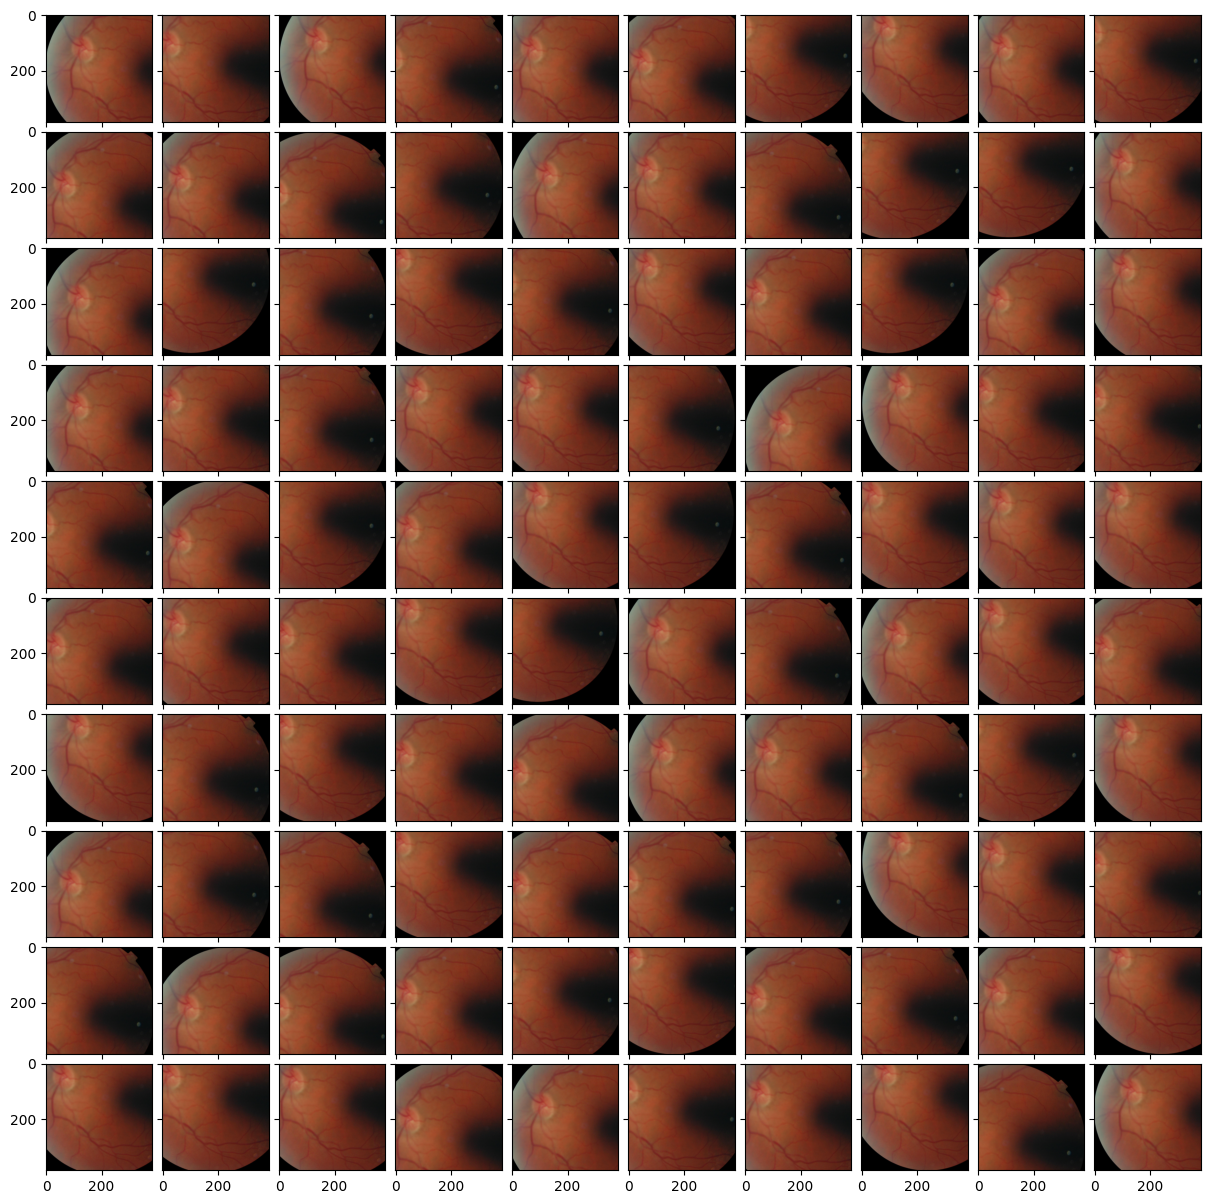

In [134]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, i in zip(grid, list(range(100))):
    # Iterating over the grid returns the Axes.
    ax.imshow(transforms.ToPILImage()(invTrans(img_batch[i])))

plt.show()

In [144]:
import onnxruntime as ort
import numpy as np
partitions = [p for p in range(22)]
def predict_batch(img_batch): 
    loghs = []
    for partition in tqdm(partitions):
        onnx_encoder = ort.InferenceSession(f'../onnx/models/{partition}_encoder.onnx')
        latent = onnx_encoder.run(None, {'input': img_batch.numpy()})

        onnx_head = ort.InferenceSession(f'../onnx/models/{partition}_head.onnx')
        loghs_partition = onnx_head.run(None, {'input': latent[0]})[1]
        loghs.append({"partition": partition, "loghs": loghs_partition})
    
    return loghs

In [145]:
data_images = pd.read_stata("../Data/StudyData/BiHealth_20230313_Long.dta")

rows = []
for i, row in tqdm(list(data_images.iterrows())):
    img_name = row["distfilename"]
    img_batch = prep_image(img_name)
    loghs = predict_batch(img_batch)
    row = {"img_name": img_name, "loghs": loghs}
    rows.append(row)

  0%|                                                                                                                                            | 3/16042 [14:35<1299:35:33, 291.70s/it]


KeyboardInterrupt: 

In [77]:
loghs

array([[0.92290306, 2.2888734 , 1.9447693 , ..., 2.4491928 , 0.38577607,
        1.5660615 ]], dtype=float32)

In [43]:
min(img_pil.size)

1904

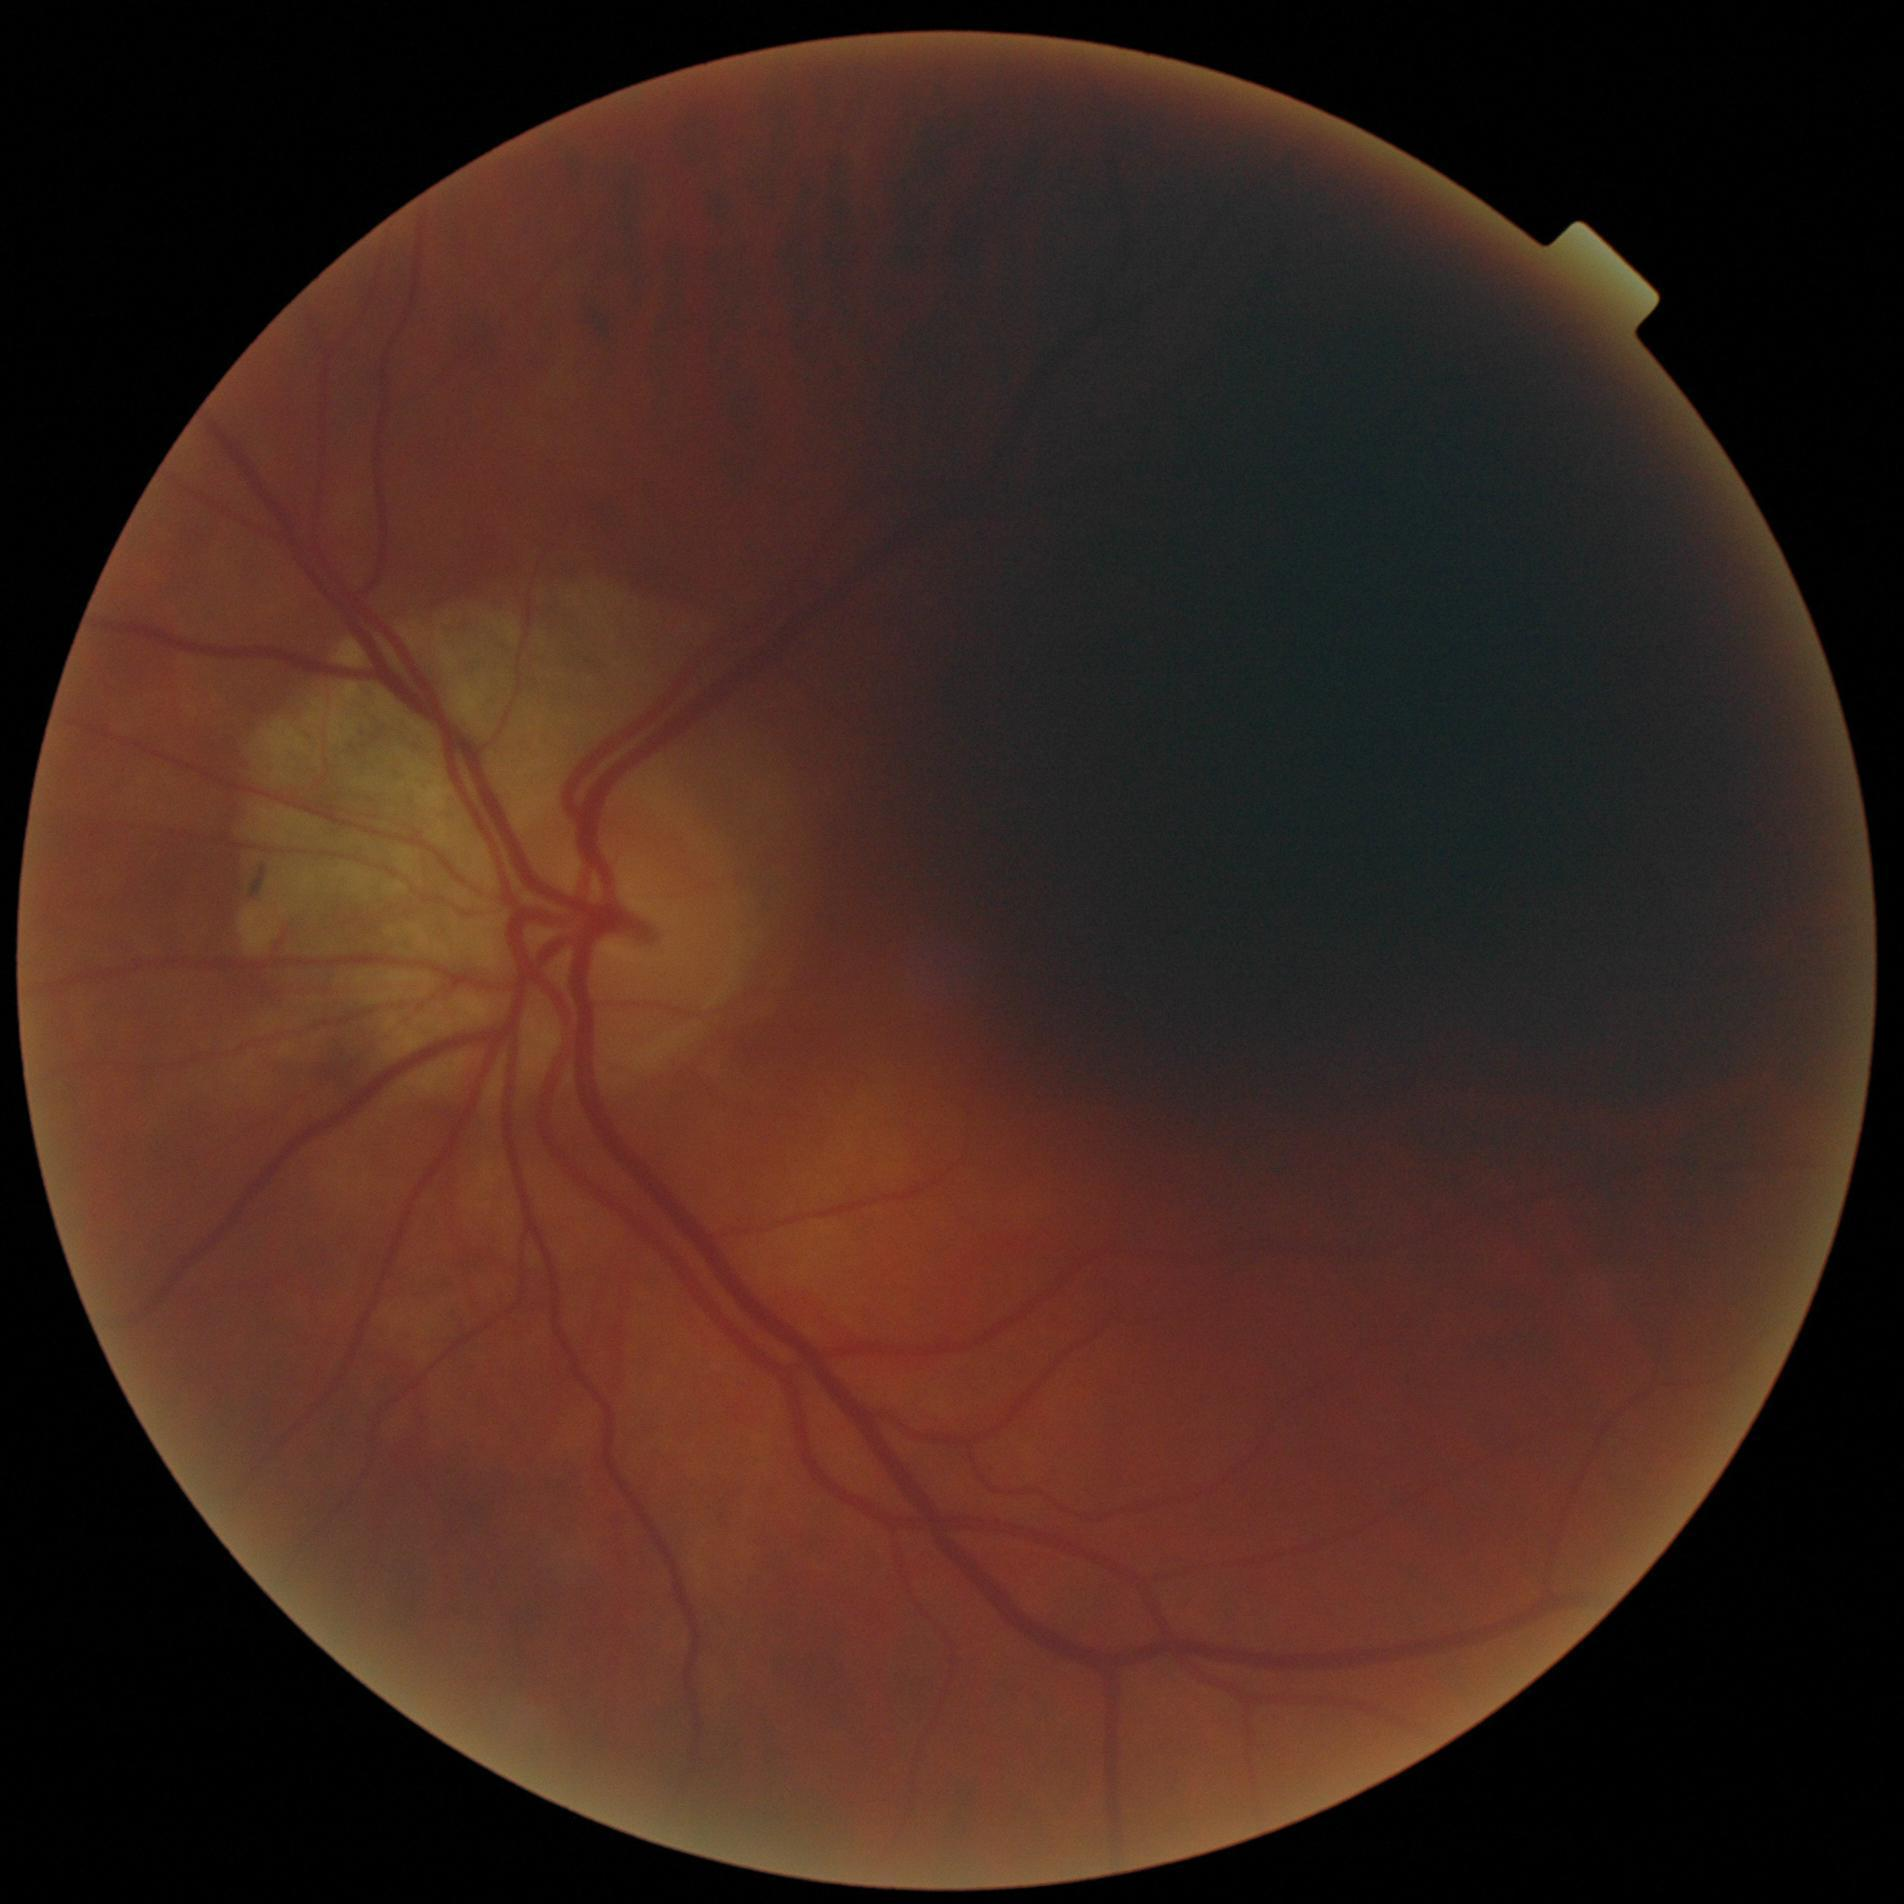

In [41]:
img_pil

In [19]:
img_batch.shape

torch.Size([1, 3, 224, 224])

In [11]:
img.shape

(1904, 1904, 3)

In [ ]:
class WritePredictionsDataFrame(Callback):
    """
    Write Predictions.
    """

    def __init__(self, **kwargs):
        super().__init__()

    # def on_exception(self, trainer, module):
    #    self.on_fit_end(trainer, module)

    def manual(self, args, datamodule, module, testtime_crop_ratios=None):
        print("Write predictions and patient embeddings")
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        
        ckpt = torch.load(args.model.restore_from_ckpt, map_location=device)
        #ckpt = torch.load(args.model.restore_from_ckpt)
        module.load_state_dict(ckpt["state_dict"])
        module.eval()

        module.to(device)

        # write the predictions, could be extended for all sets, just works if not shuffled
        endpoints = list(datamodule.label_mapping.keys())

        predictions_dfs = []

        if testtime_crop_ratios is None:
            testtime_crop_ratios = [None]

        # add the functionality of running multiple predictions w/ different TTA settings!
        for crop_ratio in testtime_crop_ratios:

            for split in tqdm(["train", "valid", "test"]):
                # overwrite transforms in  train/test/valid according to the TTA settings!
                if crop_ratio is not None:
                    t = transforms.Compose([
                        AdaptiveRandomCropTransform(crop_ratio=crop_ratio,
                                                    out_size=datamodule.img_size_to_gpu,
                                                    interpolation=PIL.Image.BICUBIC),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
                    ])

                if split == "train":
                    if crop_ratio is not None:
                        datamodule.train_dataset.transforms = t
                    dataloader = datamodule.train_dataloader(shuffle=False, drop_last=False, testtime=True)
                if split == "valid":
                    if crop_ratio is not None:
                        datamodule.valid_dataset.transforms = t
                    dataloader = datamodule.val_dataloader(testtime=True)
                if split == "test":
                    datamodule.test_dataset = datamodule.get_retina_dataset(set="test")
                    if crop_ratio is not None:
                        datamodule.test_dataset.transforms = t
                    dataloader = datamodule.test_dataloader(testtime=True)

                outputs = self.predict_dataloader(module, dataloader, device)

                index = dataloader.dataset.retina_map['eid'].values
                if args.datamodule.img_n_testtime_views > 1:
                    # prepare tta index:
                    index = []
                    for i in dataloader.dataset.retina_map['eid'].values:
                        index.extend([i]*args.datamodule.img_n_testtime_views)

                predictions_df = pd.DataFrame(
                    data=outputs["preds"],
                    index=index,
                    columns=endpoints
                ).reset_index(drop=False)
                predictions_df = annotate_df(predictions_df, datamodule, module).assign(split=split)
                predictions_dfs.append(predictions_df)

            predictions_dfs_cc = pd.concat(predictions_dfs, axis=0).reset_index(drop=True)

            # write to disk
            outdir = os.path.join(Path(args.model.restore_from_ckpt).parent, "predictions")
            if not os.path.exists(outdir):
                os.mkdir(outdir)

            tag = f"_cropratio{str(crop_ratio)}" if crop_ratio is not None else ''
            predictions_dfs_cc.to_feather(os.path.join(outdir, f"predictions{tag}.feather"))
            print(f"Predictions saved {os.path.join(outdir, f'predictions{tag}.feather')}")

            del predictions_df
            del dataloader